# TP3 Big Data

#### Parte 1  - Creación de variables, histogramas, kernels y resumen de la base de datos final

En el codigo de abajo es como obtuvimos la Base-Final con la cual vamos a trabajar.

In [4]:
import pandas as pd
from mappings import STRING_MAPPINGS

df_2024 = pd.read_excel("usu_individual_T124.xlsx")
df_2004 = pd.read_stata("usu_individual_T104.dta")

df_2004.columns = df_2004.columns.str.upper()
df_2024.columns = df_2024.columns.str.upper()

df_2024['REGION'] = df_2024['REGION'].astype(str)
df_2004['REGION'] = df_2004['REGION'].astype(str)

def apply_mappings(df, col, mapping):
    """Aplica los mapeos a una columna específica."""
    if col == 'CH14':
        if df.equals(df_2004):
            return df[col].replace(mapping)
        else:
            return df[col].apply(
                lambda x: mapping.get(str(int(x)).zfill(2)) 
                if pd.notnull(x) and isinstance(x, (int, float)) and float(x).is_integer() 
                else mapping.get(str(x).strip(), x)
            )
    else:
        return df[col].astype(str).str.strip().map(mapping).fillna(df[col])

for col, mapping in STRING_MAPPINGS.items():
    df_2004[col] = apply_mappings(df_2004, col, mapping)
    df_2024[col] = apply_mappings(df_2024, col, mapping)

df_2004 = df_2004[df_2004['REGION'] == "Pampeana"].copy()
df_2024 = df_2024[df_2024['REGION'] == "Pampeana"].copy()

df_combined = pd.concat([df_2004, df_2024], 
                       ignore_index=True, 
                       join='outer')

df_combined.to_excel("Base_Final.xlsx", index=False)

C:\Users\puchi\AppData\Local\Temp\ipykernel_4672\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].astype(str).str.strip().map(mapping).fillna(df[col])
C:\Users\puchi\AppData\Local\Temp\ipykernel_4672\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].astype(str).str.strip().map(mapping).fillna(df[col])
C:\Users\puchi\AppData\Local\Temp\ipykernel_4672\1856469427.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call r

##### Ejercicio 1

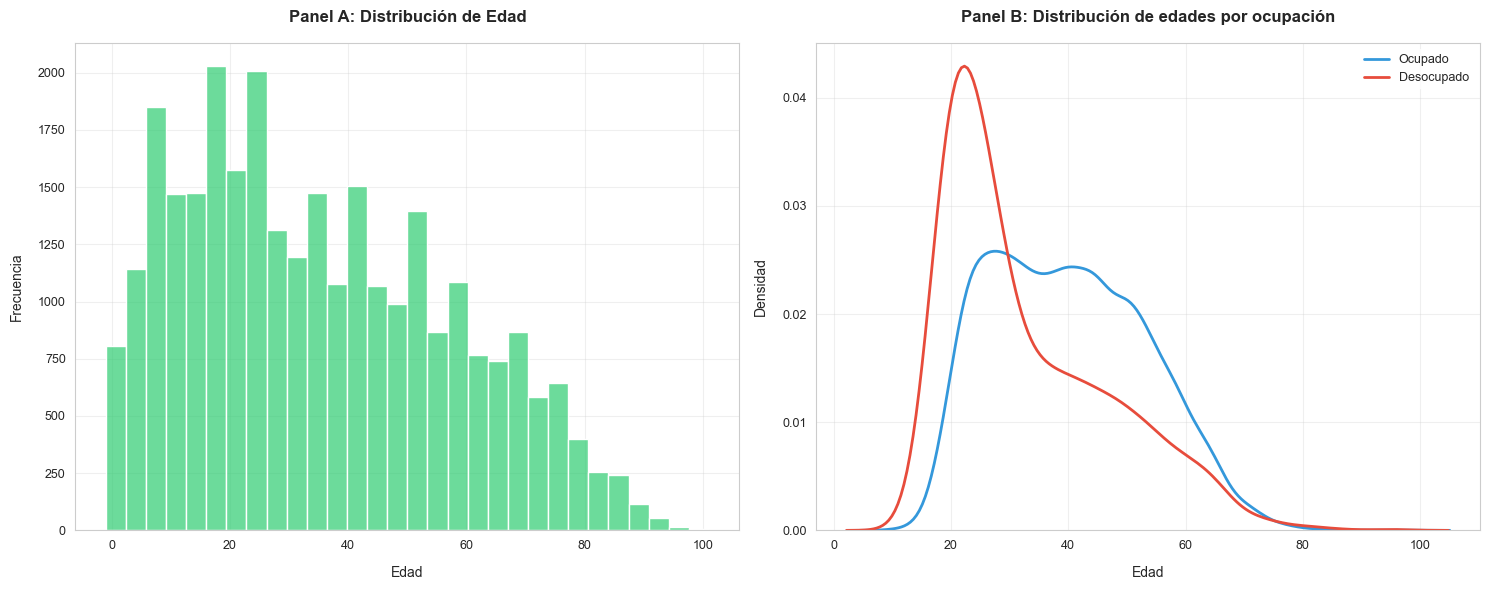

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['grid.alpha'] = 0.3

df = pd.read_excel('Base_Final.xlsx')

df['CH06'] = pd.to_numeric(df['CH06'], errors='coerce')
df['edad2'] = df['CH06'] ** 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(data=df, x='CH06', bins=30, ax=ax1, color='#2ecc71', alpha=0.7)
ax1.set_title('Panel A: Distribución de Edad', fontsize=12, pad=15, fontweight='bold')
ax1.set_xlabel('Edad', fontsize=10, labelpad=10)
ax1.set_ylabel('Frecuencia', fontsize=10, labelpad=10)
ax1.tick_params(axis='both', which='major', labelsize=9)
ax1.grid(True, alpha=0.3)


sns.kdeplot(data=df[df['ESTADO'] == 'Ocupado'], x='CH06', label='Ocupado', 
            color='#3498db', ax=ax2, linewidth=2)
sns.kdeplot(data=df[df['ESTADO'] == 'Desocupado'], x='CH06', label='Desocupado', 
            color='#e74c3c', ax=ax2, linewidth=2)
ax2.set_title('Panel B: Distribución de edades por ocupación', fontsize=12, pad=15, fontweight='bold')
ax2.set_xlabel('Edad', fontsize=10, labelpad=10)
ax2.set_ylabel('Densidad', fontsize=10, labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=9)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9, frameon=True, facecolor='white', edgecolor='none')

plt.tight_layout()
plt.show()

Panel A muestra una gran concentración de personas jóvenes (hasta 30 años), lo que probablemente se debe a que estás trabajando con un dataset donde la mayoría son jóvenes.

Panel B muestra que los desocupados tienen una mayor dispersión en su distribución de edades, lo que indica que hay desocupados tanto en los rangos jóvenes como en edades mayores, mientras que los ocupados se concentran más en las edades jóvenes.

##### Ejercicio 2

In [6]:
df['CH12'] = df['CH12'].replace(['0', 'Ns./Nr.', '99', 'Jardín/preescolar', 'Jardín/Preescolar'], 'No tiene')
df['CH12'] = df['CH12'].replace(['EGB'], 'Primario')
df['CH12'] = df['CH12'].replace(['Educación especial (discapacitado)'], 'No tiene')

años_base = {
    'Primario': 6,
    'Secundario': 12,
    'Polimodal': 12,
    'Superior no universitario': 15,
    'Universitario': 17,
    'Terciario': 15,
}


def calcular_años_educacion(row):
    nivel = row['CH12']
    finalizo = row['CH13']
    año_aprobado = row['CH14']
    
    if pd.isna(nivel) or nivel == 'No tiene':
        return 0
    
    if finalizo == 'Sí':
        return años_base.get(nivel, 0)
    else:
        base = 0
        if nivel in ['Secundario', 'Polimodal']:
            base = 6
        elif nivel in ['Terciario', 'Superior no universitario', 'Universitario']:
            base = 12

        try:
            return base + int(año_aprobado)
        except:
            return base

df['educ'] = df.apply(calcular_años_educacion, axis=1)

descripcion = df['educ'].describe()

print("Estadísticas descriptivas de años de educación:\n")
print(f"Promedio: {descripcion['mean']:.2f} años")
print(f"Desviación estándar: {descripcion['std']:.2f}")
print(f"Mínimo: {descripcion['min']:.0f} años")
print(f"Mediana (p50): {descripcion['50%']:.0f} años")
print(f"Máximo: {descripcion['max']:.0f} años")

Estadísticas descriptivas de años de educación:

Promedio: 8.52 años
Desviación estándar: 5.04
Mínimo: 0 años
Mediana (p50): 8 años
Máximo: 21 años


A partir de esta construcción, se observó que el promedio de años de educación es de 8,27 años, con una desviación estándar de 4,87. El valor mínimo es 0 años, correspondiente a personas sin educación formal, mientras que el máximo es 21 años, lo que indicaría estudios de posgrado completos. La mediana es de 8 años, lo cual indica que al menos la mitad de los individuos en la muestra no completaron el nivel secundario.

##### Ejercicio 3

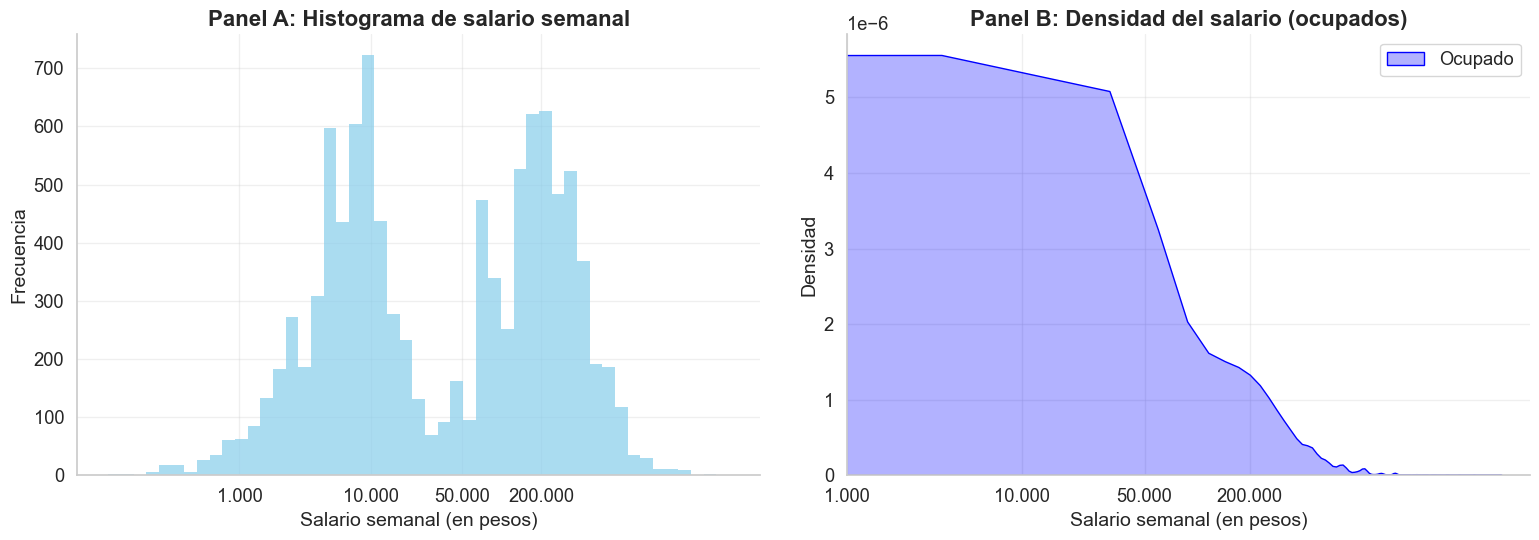

In [7]:
#Variable salario_semanal:
df = pd.read_excel("Base_Final.xlsx")

df.loc[df['ANO4'] == 2004, 'P21'] = df.loc[df['ANO4'] == 2004, 'P21'] * 18000

df['salario_semanal'] = df['P21'] / 40

# Graficos: 

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

ticks = [1000, 10000, 50000, 200000]
labels = [f"{t:,}".replace(",", ".") for t in ticks]

min_salario = df['salario_semanal'][df['salario_semanal'] > 0].min()
max_salario = df['salario_semanal'].max()
log_bins = np.logspace(np.log10(min_salario), np.log10(max_salario), 50)

plt.figure(figsize=(16,6))

plt.subplot(1, 2, 1)
sns.histplot(
    data=df, 
    x="salario_semanal", 
    bins=log_bins, 
    color="skyblue", 
    edgecolor="black", 
    alpha=0.7
)
plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Salario semanal (en pesos)')
plt.ylabel('Frecuencia')
plt.title("Panel A: Histograma de salario semanal", fontweight='bold')
sns.despine()

plt.subplot(1, 2, 2)
ocupado_data = df[(df['ESTADO'] == 'Ocupado') & (df['salario_semanal'] > 0)]

if not ocupado_data.empty:
    sns.kdeplot(data=ocupado_data, x='salario_semanal', label='Ocupado', color='blue', fill=True, alpha=0.3)

plt.xscale('log')
plt.xticks(ticks, labels)
plt.xlabel('Salario semanal (en pesos)')
plt.ylabel('Densidad')
plt.title('Panel B: Densidad del salario (ocupados)', fontweight='bold')
plt.legend()
sns.despine()

plt.tight_layout(pad=2)
plt.show()

En conjunto, los gráficos sugieren una estructura salarial desigual, con una parte significativa de la población concentrada en niveles bajos y medios de ingreso, y una minoría con salarios más elevados. La bimodalidad podría reflejar diferencias por tipo de ocupación, nivel de formalidad o calificación laboral.

##### Ejercicio 4

In [8]:
df['PP3E_TOT'] = pd.to_numeric(df['PP3E_TOT'], errors='coerce')
df['PP3F_TOT'] = pd.to_numeric(df['PP3F_TOT'], errors='coerce')

df['horastrab'] = df['PP3E_TOT'] + df['PP3F_TOT']

df_Htrabajo_limpio = df[(df['horastrab'] > 0) & (df['horastrab'] <= 168)]
descripcion_limpia = df_Htrabajo_limpio['horastrab'].describe()

print("Comparación de estadísticas descriptivas:\n")
print("Estadísticas con valores > 168 horas:")
print(f"Número de observaciones: {len(df[df['horastrab'] > 168])}")
print(f"Porcentaje de datos eliminados por > 168h: {(len(df[df['horastrab'] > 168]) / len(df[df['horastrab'] > 0]) * 100):.2f}%\n")

print("Estadísticas finales (0 < horas ≤ 168):")
print(f"Promedio: {descripcion_limpia['mean']:.2f} horas")
print(f"Desviación estándar: {descripcion_limpia['std']:.2f}")
print(f"Mínimo: {descripcion_limpia['min']:.0f} horas")
print(f"Mediana (p50): {descripcion_limpia['50%']:.0f} horas")
print(f"Máximo: {descripcion_limpia['max']:.0f} horas")
print(f"Número de observaciones: {len(df_Htrabajo_limpio)}")

Comparación de estadísticas descriptivas:

Estadísticas con valores > 168 horas:
Número de observaciones: 14
Porcentaje de datos eliminados por > 168h: 0.13%

Estadísticas finales (0 < horas ≤ 168):
Promedio: 39.60 horas
Desviación estándar: 18.46
Mínimo: 1 horas
Mediana (p50): 40 horas
Máximo: 126 horas
Número de observaciones: 10979


El análisis final, que excluye tanto los valores cero como aquellos superiores a 168 horas, nos proporcionó una distribución mucho más realista y confiable. Esta distribución muestra una clara concentración alrededor de las 40-45 horas semanales, lo cual es consistente con una jornada laboral estándar.

Decidimos eliminar valores superiores a 168, porq es matematicamente imposible trabajar esas horas, sabiendo que una semana tiene 168 horas.

##### Ejercicio 5

In [9]:
df_2004 = df[df['ANO4'] == 2004]
df_2024 = df[df['ANO4'] == 2024]

cant_obs_2004 = len(df_2004)
cant_obs_2024 = len(df_2024)
cant_obs_total = len(df)

nas_estado_2004 = df_2004['ESTADO'].isna().sum()
nas_estado_2024 = df_2024['ESTADO'].isna().sum()
nas_estado_total = df['ESTADO'].isna().sum()

ocupados_2004 = (df_2004['ESTADO'] == 'Ocupado').sum()
ocupados_2024 = (df_2024['ESTADO'] == 'Ocupado').sum()
ocupados_total = (df['ESTADO'] == 'Ocupado').sum()

desocupados_2004 = (df_2004['ESTADO'] == 'Desocupado').sum()
desocupados_2024 = (df_2024['ESTADO'] == 'Desocupado').sum()
desocupados_total = (df['ESTADO'] == 'Desocupado').sum()

variables_limpias = ['var1', 'var2', 'var3', 'ESTADO', 'AÑO']  # Completa con tus variables reales
cant_variables_limpias = len(variables_limpias)

tabla_resumen = pd.DataFrame({
    '2004': [cant_obs_2004, nas_estado_2004, ocupados_2004, desocupados_2004],
    '2024': [cant_obs_2024, nas_estado_2024, ocupados_2024, desocupados_2024],
    'Total': [cant_obs_total, nas_estado_total, ocupados_total, desocupados_total]
}, index=[
    'Cantidad de observaciones',
    'Observaciones con NaN en ESTADO',
    'Cantidad de Ocupados',
    'Cantidad de Desocupados'
])

print(tabla_resumen)

print(f"\nCantidad de variables limpias y homogeneizadas: {cant_variables_limpias}")


                                  2004   2024  Total
Cantidad de observaciones        14821  14410  29231
Observaciones con NaN en ESTADO      0      0      0
Cantidad de Ocupados              5682   6302  11984
Cantidad de Desocupados           1035    453   1488

Cantidad de variables limpias y homogeneizadas: 5
